In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras
from tensorflow.keras import layers, Sequential

tf.random.set_seed(2345)

In [2]:
WDCNN=Sequential([
    layers.Conv1D(filters=16,kernel_size=(64,),strides=8,padding='same',name='conv1',batch_input_shape=(None,1024,1)),#[b,1024,1]=>[b,128,16]
    layers.MaxPooling1D(pool_size=2,strides=2,padding='valid',name='pooling1'),#[b,128,16]=>[b,64,16]
    layers.Conv1D(filters=32,kernel_size=(3,),strides=1,padding='same',name='conv2'),#[b,64,16]=>[b,64,32]
    layers.MaxPooling1D(pool_size=2,strides=2,padding='valid',name='pooling2'),#[b,64,32]=>[b,32,32]
    layers.Conv1D(filters=64,kernel_size=(3,),strides=1,padding='same',name='conv3'),#[b,32,32]=>[b,32,64]
    layers.MaxPooling1D(pool_size=2,strides=2,padding='valid',name='pooling3'),#[b,32,64]=>[b,16,64]
    layers.Conv1D(filters=64,kernel_size=(3,),strides=1,padding='same',name='conv4'),#[b,16,64]=>[b,16,64]
    layers.MaxPooling1D(pool_size=2,strides=2,padding='valid',name='pooling4'),#[b,16,64]=>[b,8,64]
    layers.Conv1D(filters=64,kernel_size=(3,),strides=1,padding='same',name='conv5'),#[b,8,64]=>[b,8,64]
    layers.MaxPooling1D(pool_size=2,strides=2,padding='valid',name='pooling5'),#[b,8,64]=>[b,4,64]
    layers.Conv1D(filters=64,kernel_size=(3,),strides=1,padding='same',name='conv6'),#[b,4,64]=>[b,4,64]
    layers.GlobalAveragePooling1D(name='pooling6'),#[b,4,64]=>[b,64]
    layers.Dense(units=32,activation='softmax',name='dense1'),
    layers.Dense(units=32,activation='softmax',name='dense2'),
    layers.Dense(units=10,activation='softmax',name='dense3')
])
WDCNN.compile(optimizer=keras.optimizers.Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
WDCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 128, 16)           1040      
_________________________________________________________________
pooling1 (MaxPooling1D)      (None, 64, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 64, 32)            1568      
_________________________________________________________________
pooling2 (MaxPooling1D)      (None, 32, 32)            0         
_________________________________________________________________
conv3 (Conv1D)               (None, 32, 64)            6208      
_________________________________________________________________
pooling3 (MaxPooling1D)      (None, 16, 64)            0         
_________________________________________________________________
conv4 (Conv1D)               (None, 16, 64)            1

In [3]:
'''
序列阶段：定义一个函数，该函数主要用于将序列数据按照步长和窗口进行序列提取
'''
import numpy as np
def seq_chunk(seq,chunk,step=None):
    if step==None:
        step=chunk
    seq_length=seq.shape[0]
    rows=(seq_length-chunk)//step+1
    new_set=np.empty(shape=(rows,chunk))
    for i in range(0,seq_length-chunk+1,step):
        new_set[i//step]=seq[i:i+chunk]
    return new_set

In [4]:
import scipy.io as scio
import pandas as pd
def mixMatSeq(maturl,classify):
    if maturl.endswith('.mat'):
        data = scio.loadmat(maturl)
        data=pd.DataFrame([data])
        tmplist=np.array([])
        for idx in data:
            if idx.endswith('_time'):
                tmp=data[idx][0]
                tmp=np.squeeze(tmp)
                tmp_chunk=seq_chunk(tmp,chunk=1024)
                if not(tmplist.any()):
                    tmplist=tmp_chunk
                else:
                    tmplist=np.vstack((tmplist,tmp_chunk))
        return (np.ones(shape=(tmplist.shape[0],))*classify).astype(np.int64),tmplist
    else:
        print('input type error,please input mat url')
        pass

In [5]:
'''
定义一个函数，将映射表传入后，可以根据文件分布，从文件中提取出所需要的标签和序列组
upperurl:CRWU文件夹所在的绝对文件路径，用'\\'作文件夹分隔符
mapdata:映射文件及路径
train_rate:从中抽取多少比例做训练集
'''
def load_data(upperurl,mapdata,train_rate=0.8):
    all_label=np.array([])
    all_sets=np.array([])
    for row in mapdata:
        url=upperurl+row['srcurl']
        labels,datasets = mixMatSeq(url,row['class'])
        if all_sets.shape[0]==0:
            all_label=labels
            all_sets=datasets
        else:
            all_label=np.hstack((all_label,labels))#横向拼接
            all_sets=np.vstack((all_sets,datasets))#纵向拼接
    # 获取所有信息并拼接成总数据集后，将总数据集随机打散，然后按照设定比例划分为训练集和测试集
    random_stack=np.hstack((all_sets,all_label.reshape((-1,1))))
    np.random.shuffle(random_stack)
    all_label=tf.one_hot(random_stack[:,-1],depth=10) # 为方便使用交叉熵，直接对label进行独热编码
    all_sets =random_stack[:,:-1]
    return (all_sets[:int(all_sets.shape[0]*train_rate)],all_label[:int(all_label.shape[0]*train_rate)]),\
           (all_sets[int(all_sets.shape[0]*train_rate):],all_label[int(all_label.shape[0]*train_rate):])

In [6]:
mapdata=[{'class':0,'faultname':'基座,健康,载荷0','srcurl':'Normal Baseline\\normal_0.mat'},
         {'class':4,'faultname':'驱动端,内圈,故障等级1,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Inner Race\\0007\\IR007_0.mat'},
         {'class':8,'faultname':'驱动端,滚珠圈,故障等级1,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Ball\\0007\\B007_0.mat'},
         {'class':12,'faultname':'驱动端,外圈,故障等级1,位置@6,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Outer Race\\Centered\\0007\\OR007@6_0.mat'},
         {'class':24,'faultname':'驱动端,内圈,故障等级2,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Inner Race\\0014\\IR014_0.mat'},
         {'class':28,'faultname':'驱动端,滚珠圈,故障等级2,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Ball\\0014\\B014_0.mat'},
         {'class':32,'faultname':'驱动端,外圈,故障等级2,位置@6,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Outer Race\\Centered\\0014\\OR014@6_0.mat'},
         {'class':36,'faultname':'驱动端,内圈,故障等级3,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Inner Race\\0021\\IR021_0.mat'},
         {'class':40,'faultname':'驱动端,滚珠圈,故障等级3,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Ball\\0021\\B021_0.mat'},
         {'class':44,'faultname':'驱动端,外圈,故障等级3,位置@6,载荷0','srcurl':'12k Drive End Bearing Fault Data\\Outer Race\\Centered\\0021\\OR021@6_0.mat'},
         ]
len(mapdata)

10

In [7]:
upperurl='D:\\BaiduNetdiskDownload\\CRWU凯斯西储大学轴承数据\\CRWU\\'
(x,y),(x_test,y_test)=load_data(upperurl,mapdata)
x=np.expand_dims(x,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)
(x.shape,y.shape),(x_test.shape,y_test.shape) #经过独热编码的y标签，是（109，）的标签数据，能与Dense层对应

(((2941, 1024, 1), TensorShape([2941, 10])),
 ((736, 1024, 1), TensorShape([736, 10])))

In [8]:
fitParam=WDCNN.fit(x,y,
          batch_size=1024,
          epochs=100,
          verbose=1,
          validation_data=(x_test,y_test))

Epoch 1/100
3/3 [==============================] - 1s 159ms/step - loss: 0.7242 - accuracy: 0.0000e+00 - val_loss: 0.8120 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 67ms/step - loss: 0.7340 - accuracy: 0.0000e+00 - val_loss: 0.8118 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 64ms/step - loss: 0.7340 - accuracy: 0.0000e+00 - val_loss: 0.8117 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 72ms/step - loss: 0.7276 - accuracy: 0.0000e+00 - val_loss: 0.8115 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 74ms/step - loss: 0.7233 - accuracy: 0.0000e+00 - val_loss: 0.8113 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 71ms/step - loss: 0.7294 - accuracy: 0.0000e+00 - val_loss: 0.8112 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 65ms/step - loss: 0.7227 - accuracy: 0.0000e+00 - val_los

In [9]:
def drawPic(fitParam,imgName):
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False # 用
    epochs = len(fitParam.history['loss'])
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    lns1 = ax1.plot(range(epochs), np.array(fitParam.history['loss']),color='blue', label="Loss",alpha=0.7)
    lns2 = ax1.plot(range(epochs), np.array(fitParam.history['val_loss']),color='crimson', label="Loss",alpha=0.7)
    # 按一定间隔显示实现方法
    # ax2.plot(200 * np.arange(len(fig_accuracy)), fig_accuracy, 'r')
    lns3 = ax2.plot(range(epochs), np.array(fitParam.history['accuracy'])*100,color='green',label="Accuracy",alpha=0.7)
    lns4 = ax2.plot(range(epochs), np.array(fitParam.history['val_accuracy'])*100,color='burlywood',label="Accuracy",alpha=0.7)
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('training loss')
    ax2.set_ylabel('training accuracy')
    # 合并图例
    lns = lns1+ lns2 + lns3+lns4
    labels = ["Loss",'Val_loss' ,'Accuracy',"Val_accuracy"]
    plt.legend(lns, labels, loc=7)
    plt.title('Loss&Accuracy')
    plt.show()

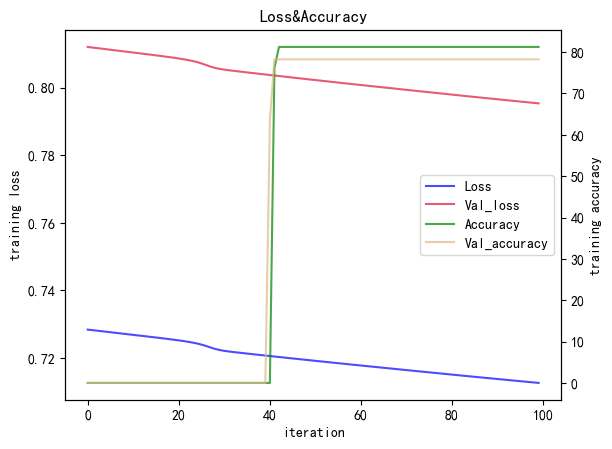

In [10]:
drawPic(fitParam,'originModelTraining')